# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.


## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [102]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import os
import re
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sb
import pickle

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from sklearn.preprocessing import StandardScaler 
#TSNE
from sklearn.manifold import TSNE
from bs4 import BeautifulSoup


In [103]:
# Temporarily Suppressing Warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

# [1]. Reading Data

In [104]:
# using the SQLite Table to read data.
# con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite')

con = sqlite3.connect('C:/Users/Saraswathi/Music/Appliedai/Data/amazon-fine-food-reviews/database.sqlite')

#filetering only positve and negative reviews
#reviews not taking in to consideration with score = 3

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 200000""", con) 
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition( x ):
    if x > 3:
        return 1 #positive
#         return 1
    else:
        return 0 #negative

#changing reviews with score less than 3 to be positive and vice versa
actual_score = filtered_data['Score']
positivenegative = actual_score.map(partition)
filtered_data['Score']=positivenegative
print('Number of data point in our data',filtered_data.shape)
filtered_data.head(5)    

Number of data point in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication
It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [105]:
display = pd.read_sql_query("""
SELECT * FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""",con)

In [106]:
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that 

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [107]:
#Sorting data according to ProductId in ascending order
sorted_data = filtered_data.sort_values('ProductId',axis=0,ascending= True, inplace=False, kind ='quicksort',na_position='last')

In [108]:
#Duplication of entries
final = sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'}, keep = 'first' , inplace= False)
final.shape

(364173, 10)

In [109]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

Observation:- It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions
    

In [110]:
display = pd.read_sql_query("""
SELECt * 
FROM Reviews
WHERE Score !=3 AND Id=44737 OR Id=64422
ORDER BY ProductId
""",con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [111]:
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

In [112]:
final.shape
final['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

# [3] Text Preprocessing.

## [3.1].  Preprocessing Review Text


Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [113]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [114]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [115]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
# for sentance in tqdm(final['Text'].values):
for sentance in final['Text'].values:
    sentance = re.sub(r"http\S+","",sentance)
    sentance = BeautifulSoup(sentance,'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*","",sentance).strip()
    sentance = re.sub('[^A-Za-z]+',' ',sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)  
    preprocessed_reviews.append(sentance.strip())

In [116]:
preprocessed_reviews[100]

'pros dog anything treat not smell bad many treats easy break smaller pieces nothing artificial easy digestion cons costly dog treats overall great product expensive dog anything treat several phobias including getting car walking doorways ignores fears get treat'

## [3.2].  Preprocessing Summary

In [117]:
##preprocessing for review summary also.

# Combining all the above stundents 
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
# for sentance in tqdm(final['Summary'].values):
for sentance in (final['Summary'].values):

    sentance = re.sub(r"http\S+","",sentance)
    sentance = BeautifulSoup(sentance,'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*","",sentance).strip()
    sentance = re.sub('[^A-Za-z]+',' ',sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)  
    preprocessed_summary.append(sentance.strip())

In [118]:
preprocessed_summary[100]

'awesome'

# [5] Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
<!--     <img src='train_cv_auc.JPG' width=300px></li> -->
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
<!--     <img src='train_test_auc.JPG' width=300px></li> -->
    <li>Along with plotting ROC curve, you need to print theconfusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
<!--     <img src='confusion_matrix.png' width=300px></li> -->
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
<!--         <img src='summary.JPG' width=400px> -->
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Multinomial Naive Bayes

In [119]:
final['cleaned_text'] = preprocessed_reviews
final['cleaned_summary'] = preprocessed_summary
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text,cleaned_summary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,every book educational
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...,love book miss hard cover version
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...,chicken soup rice months
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great little book read aloud nice rhythm well ...,good swingy rhythm reading aloud
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetry months year goes month cute little...,great way learn months


#### As data is time series data. So, first sort the data based on time 

In [120]:
final_sort_data = final.sort_values('Time',axis = 0, ascending= True, inplace= False, kind= 'quicksort',na_position='last')


In [121]:
#Train,CV,test split
final_train_cv_data = final_sort_data[:int((final_sort_data.shape[0]*70)/100)] # slice first 70% points in training set and rest 30% points in test set. 
final_sort_test_data = final_sort_data[int((final_sort_data.shape[0]*70)/100)+1:]
final_sort_train_data = final_train_cv_data[:int((final_train_cv_data.shape[0]*70)/100)] # slice first 70% points in training set and rest 30% points in test
final_sort_cv_data = final_train_cv_data[int((final_train_cv_data.shape[0]*70)/100)+1:]

# print(final_train_cv_data.shape)
print(final_sort_test_data.shape)
print(final_sort_cv_data.shape)
print(final_sort_train_data.shape)
# print(final_sort_train_data.columns)

x_train = final_sort_train_data['cleaned_text']
y_train = np.array(final_sort_train_data['Score'])
x_cv = final_sort_cv_data['cleaned_text']
y_cv = np.array(final_sort_cv_data['Score'])
x_test = final_sort_test_data['cleaned_text']
y_test = np.array(final_sort_test_data['Score'])

x_train[100]

(109251, 12)
(76475, 12)
(178443, 12)


'diappointed flavor texture mix usually like low carb things tried diappointed specific one'

## [5.1] Applying Naive Bayes on BOW

In [122]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score,auc

In [123]:

cou_vec = CountVectorizer()
final_x_train = cou_vec.fit_transform(x_train)
final_x_cv = cou_vec.transform(x_cv)
final_x_test = cou_vec.transform(x_test)

auc_train = []
auc_cv = []

print(final_x_cv.shape)

(76475, 79848)


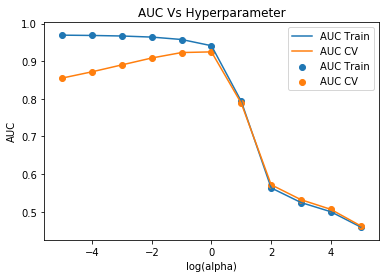

Optimal alpha for which AUC is maximum : 1


In [124]:
import math
alpha_values = [10**-5,10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4,10**5]

for i in alpha_values:
    naive = MultinomialNB(alpha = i,class_prior = [0.5,0.5])
    naive.fit(final_x_train, y_train)
    
    y_train_pred_prob = naive.predict_proba(final_x_train)[:,1]
    y_cv_pred_prob = naive.predict_proba(final_x_cv)[:,1]
    
    auc_train.append(roc_auc_score(y_train,y_train_pred_prob))
    auc_cv.append(roc_auc_score(y_cv,y_cv_pred_prob))
    
optimal_alpha = alpha_values[auc_cv.index(max(auc_cv))]
alpha_values = [np.log10(x) for x in alpha_values]

plt.plot(alpha_values, auc_train, label='AUC Train')
plt.scatter(alpha_values, auc_train, label='AUC Train')
plt.plot(alpha_values,auc_cv,label = 'AUC CV')
plt.scatter(alpha_values,auc_cv,label = 'AUC CV')

plt.title('AUC Vs Hyperparameter')
plt.xlabel('log(alpha)')
plt.ylabel('AUC')
plt.legend()
plt.show()

print('Optimal alpha for which AUC is maximum :',optimal_alpha)


#### Testing with Test data

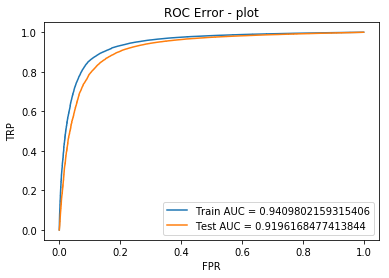

In [125]:
#Roc for alpha = 1
naive = MultinomialNB(alpha= optimal_alpha)
naive.fit(final_x_train,y_train)

train_prob = naive.predict_proba(final_x_train)[:,1]
test_prob = naive.predict_proba(final_x_test)[:,1]


train_fpr, train_tpr, thresholds = metrics.roc_curve(y_train, train_prob )
test_fpr, test_tpr, thresholds1 = metrics.roc_curve(y_test,test_prob)

plt.plot(train_fpr, train_tpr, label='Train AUC = ' + str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr, label = 'Test AUC = ' + str(auc(test_fpr,test_tpr)))

plt.xlabel('FPR')
plt.ylabel('TRP')
plt.title('ROC Error - plot')
plt.legend()
plt.show()


#### Confusion Matrix

Confusion Matrix for train data


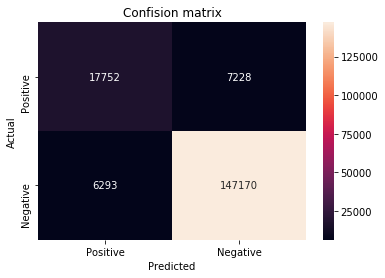

Confusion matrix for test data


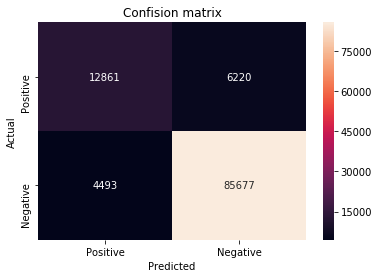

In [126]:
#confusion matrix using heatmap for train data
print('Confusion Matrix for train data')
conf_matr = confusion_matrix(y_train, naive.predict(final_x_train))
class_labes = ['Positive','Negative']
df = pd.DataFrame(conf_matr, index= class_labes, columns=class_labes)
sb.heatmap(df, annot= True ,fmt = 'd')
plt.title('Confision matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
#confusion matrix using heatmap for test data

print('Confusion matrix for test data')
conf_matr = confusion_matrix(y_test, naive.predict(final_x_test))
class_labes = ['Positive','Negative']
df = pd.DataFrame(conf_matr, index= class_labes, columns=class_labes)
sb.heatmap(df, annot= True ,fmt = 'd')
plt.title('Confision matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### [5.1.1] Top 10 important features of positive class

In [127]:
naive = MultinomialNB(alpha = optimal_alpha)
naive.fit(final_x_train,y_train)

features = naive.feature_log_prob_ #log probability of features given a class
feature_names = cou_vec.get_feature_names()
positive_features = np.argsort(features[1])[::-1] # a[::-1] all items in the array, reversed
negative_features = np.argsort(features[0])[::-1] # Returns the indices that would sort an array
print("Top 10 important features of positive class from BOW")

# for i in list(positive_features[0:10]):
for i in list(positive_features[0:10]):
    print(feature_names[i])

Top 10 important features of positive class from BOW
not
like
good
great
one
tea
taste
flavor
love
product


### [5.1.2] Top 10 important features of negative class

In [128]:
print("Top 10 important features of negative class from BOW")
for i in list(negative_features[0:10]):
    print(feature_names[i])

Top 10 important features of negative class from BOW
not
like
would
product
taste
one
good
no
flavor
coffee


## [5.2] Applying Naive Bayes on TFIDF

In [129]:
tf_idf_vect = TfidfVectorizer(min_df= 10) 
final_x_train = tf_idf_vect.fit_transform(x_train)
final_x_cv = tf_idf_vect.transform(x_cv)
final_x_test = tf_idf_vect.transform(x_test)

auc_train = []
auc_cv = []

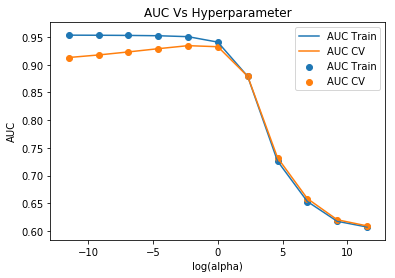

Optimal alpha for which AUC is maximum : 0.1


In [130]:
import math
alpha_values = [10**-5,10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4,10**5]

for i in alpha_values:
    naive = MultinomialNB(alpha = i,class_prior = [0.5,0.5])
    naive.fit(final_x_train, y_train)
    
    y_train_pred_prob = naive.predict_proba(final_x_train)[:,1]
    y_cv_pred_prob = naive.predict_proba(final_x_cv)[:,1]
    
    auc_train.append(roc_auc_score(y_train,y_train_pred_prob))
    auc_cv.append(roc_auc_score(y_cv,y_cv_pred_prob))


    
optimal_alpha = alpha_values[auc_cv.index(max(auc_cv))]
alpha_values = [np.log(x) for x in alpha_values]

plt.plot(alpha_values, auc_train, label='AUC Train')
plt.scatter(alpha_values, auc_train, label='AUC Train')
plt.plot(alpha_values,auc_cv,label = 'AUC CV')
plt.scatter(alpha_values,auc_cv,label = 'AUC CV')

plt.title('AUC Vs Hyperparameter')
plt.xlabel('log(alpha)')
plt.ylabel('AUC')
plt.legend()
plt.show()

print('Optimal alpha for which AUC is maximum :',optimal_alpha)


#### Testing with Test data

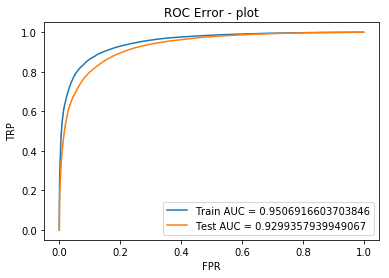

In [131]:
#Roc for alpha = 1
naive = MultinomialNB(alpha= optimal_alpha)
naive.fit(final_x_train,y_train)

train_prob = naive.predict_proba(final_x_train)[:,1]
test_prob = naive.predict_proba(final_x_test)[:,1]


train_fpr, train_tpr, thresholds = metrics.roc_curve(y_train, train_prob )
test_fpr, test_tpr, thresholds1 = metrics.roc_curve(y_test,test_prob)

plt.plot(train_fpr, train_tpr, label='Train AUC = ' + str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr, label = 'Test AUC = ' + str(auc(test_fpr,test_tpr)))

plt.xlabel('FPR')
plt.ylabel('TRP')
plt.title('ROC Error - plot')
plt.legend()
plt.show()


#### Confusion Matrix

Confusion Matrix for train data


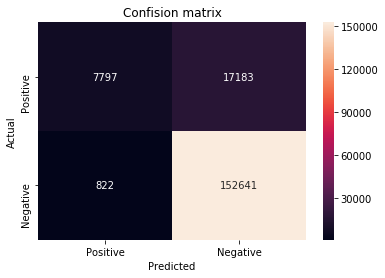

Confusion matrix for test data


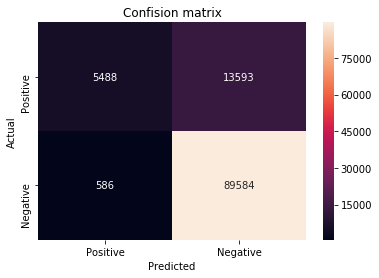

In [132]:
#confusion matrix using heatmap for train data
print('Confusion Matrix for train data')
conf_matr = confusion_matrix(y_train, naive.predict(final_x_train))
class_labes = ['Positive','Negative']
df = pd.DataFrame(conf_matr, index= class_labes, columns=class_labes)
sb.heatmap(df, annot= True ,fmt = 'd')
plt.title('Confision matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
#confusion matrix using heatmap for test data

print('Confusion matrix for test data')
conf_matr = confusion_matrix(y_test, naive.predict(final_x_test))
class_labes = ['Positive','Negative']
df = pd.DataFrame(conf_matr, index= class_labes, columns=class_labes)
sb.heatmap(df, annot= True ,fmt = 'd')
plt.title('Confision matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### [5.2.1] Top 10 important features of positive class

In [133]:
naive = MultinomialNB(alpha = optimal_alpha)
naive.fit(final_x_train,y_train)

features = naive.feature_log_prob_ #log probability of features given a class
feature_names = tf_idf_vect.get_feature_names()
positive_features = np.argsort(features[1])[::-1] # a[::-1] all items in the array, reversed
negative_features = np.argsort(features[0])[::-1] # Returns the indices that would sort an array
print("Top 10 important features of positive class from BOW")

# for i in list(positive_features[0:10]):
for i in list(positive_features[0:10]):
    print(feature_names[i])


Top 10 important features of positive class from BOW
not
great
good
tea
like
coffee
love
product
taste
one


### [5.2.2] Top 10 important features of negative class from

In [134]:
print("Top 10 important features of negative class from BOW")
for i in list(negative_features[0:10]):
    print(feature_names[i])

Top 10 important features of negative class from BOW
not
like
taste
product
would
coffee
one
flavor
no
good


## [5.3] Feature engineering

In [135]:
#Adding preprocessed summary and review length to preprocessed summary
# for i in range(len(preprocessed_reviews)):
#     preprocessed_reviews[i] += ' '+preprocessed_summary[i]+ ' ' + str(len(final.Text.iloc[i]))
    
# preprocessed_reviews[100]
# print(final['cleaned_text'][100])

final['cleaned_text'] = final['cleaned_text'] + ' ' + final['cleaned_summary'] + ' ' + str(len(final['cleaned_text']))

print(final['cleaned_text'][100])


diappointed flavor texture mix usually like low carb things tried diappointed specific one low carb angel food puffs 364171


## [5.4] Applying Naive Bayes on BOW

In [136]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text,cleaned_summary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,every book educational
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...,love book miss hard cover version
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...,chicken soup rice months
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great little book read aloud nice rhythm well ...,good swingy rhythm reading aloud
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetry months year goes month cute little...,great way learn months


#### As data is time series data. So, first sort the data based on time 

In [137]:
final_sort_data = final.sort_values('Time',axis = 0, ascending= True, inplace= False, kind= 'quicksort',na_position='last')


In [138]:
#Train,CV,test split
final_train_cv_data = final_sort_data[:int((final_sort_data.shape[0]*70)/100)] # slice first 70% points in training set and rest 30% points in test set. 
final_sort_test_data = final_sort_data[int((final_sort_data.shape[0]*70)/100)+1:]
final_sort_train_data = final_train_cv_data[:int((final_train_cv_data.shape[0]*70)/100)] # slice first 70% points in training set and rest 30% points in test
final_sort_cv_data = final_train_cv_data[int((final_train_cv_data.shape[0]*70)/100)+1:]

# print(final_train_cv_data.shape)
print(final_sort_test_data.shape)
print(final_sort_cv_data.shape)
print(final_sort_train_data.shape)
# print(final_sort_train_data.columns)

x_train = final_sort_train_data['cleaned_text']
y_train = np.array(final_sort_train_data['Score'])
x_cv = final_sort_cv_data['cleaned_text']
y_cv = np.array(final_sort_cv_data['Score'])
x_test = final_sort_test_data['cleaned_text']
y_test = np.array(final_sort_test_data['Score'])

x_train[100]

(109251, 12)
(76475, 12)
(178443, 12)


'diappointed flavor texture mix usually like low carb things tried diappointed specific one low carb angel food puffs 364171'

In [139]:

cou_vec = CountVectorizer()
final_x_train = cou_vec.fit_transform(x_train)
final_x_cv = cou_vec.transform(x_cv)
final_x_test = cou_vec.transform(x_test)

auc_train = []
auc_cv = []

print(final_x_cv.shape)

(76475, 83285)


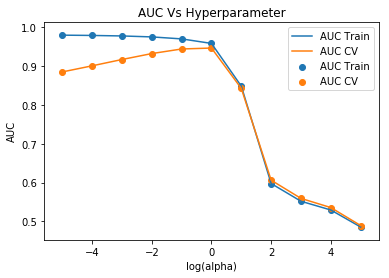

Optimal alpha for which AUC is maximum : 1


In [140]:
import math
alpha_values = [10**-5,10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4,10**5]

for i in alpha_values:
    naive = MultinomialNB(alpha = i,class_prior = [0.5,0.5])
    naive.fit(final_x_train, y_train)
    
    y_train_pred_prob = naive.predict_proba(final_x_train)[:,1]
    y_cv_pred_prob = naive.predict_proba(final_x_cv)[:,1]
    
    auc_train.append(roc_auc_score(y_train,y_train_pred_prob))
    auc_cv.append(roc_auc_score(y_cv,y_cv_pred_prob))
    
optimal_alpha = alpha_values[auc_cv.index(max(auc_cv))]
alpha_values = [np.log10(x) for x in alpha_values]

plt.plot(alpha_values, auc_train, label='AUC Train')
plt.scatter(alpha_values, auc_train, label='AUC Train')
plt.plot(alpha_values,auc_cv,label = 'AUC CV')
plt.scatter(alpha_values,auc_cv,label = 'AUC CV')

plt.title('AUC Vs Hyperparameter')
plt.xlabel('log(alpha)')
plt.ylabel('AUC')
plt.legend()
plt.show()

print('Optimal alpha for which AUC is maximum :',optimal_alpha)


#### Testing with Test data

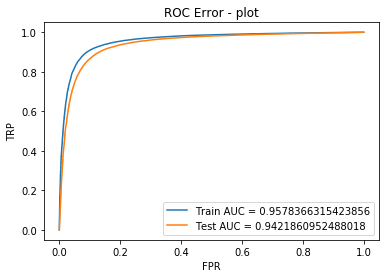

In [141]:
#Roc for alpha = 1
naive = MultinomialNB(alpha= optimal_alpha)
naive.fit(final_x_train,y_train)

train_prob = naive.predict_proba(final_x_train)[:,1]
test_prob = naive.predict_proba(final_x_test)[:,1]


train_fpr, train_tpr, thresholds = metrics.roc_curve(y_train, train_prob )
test_fpr, test_tpr, thresholds1 = metrics.roc_curve(y_test,test_prob)

plt.plot(train_fpr, train_tpr, label='Train AUC = ' + str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr, label = 'Test AUC = ' + str(auc(test_fpr,test_tpr)))

plt.xlabel('FPR')
plt.ylabel('TRP')
plt.title('ROC Error - plot')
plt.legend()
plt.show()


#### Confusion Matrix

Confusion Matrix for train data


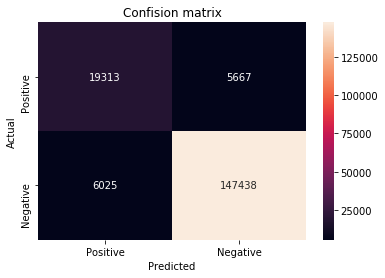

Confusion matrix for test data


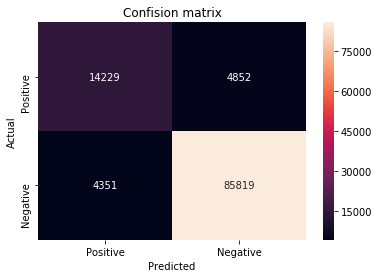

In [142]:
#confusion matrix using heatmap for train data
print('Confusion Matrix for train data')
conf_matr = confusion_matrix(y_train, naive.predict(final_x_train))
class_labes = ['Positive','Negative']
df = pd.DataFrame(conf_matr, index= class_labes, columns=class_labes)
sb.heatmap(df, annot= True ,fmt = 'd')
plt.title('Confision matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
#confusion matrix using heatmap for test data

print('Confusion matrix for test data')
conf_matr = confusion_matrix(y_test, naive.predict(final_x_test))
class_labes = ['Positive','Negative']
df = pd.DataFrame(conf_matr, index= class_labes, columns=class_labes)
sb.heatmap(df, annot= True ,fmt = 'd')
plt.title('Confision matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### [5.4.1] Top 10 important features of positive class

In [143]:
naive = MultinomialNB(alpha = optimal_alpha)
naive.fit(final_x_train,y_train)

features = naive.feature_log_prob_ #log probability of features given a class
feature_names = cou_vec.get_feature_names()
positive_features = np.argsort(features[1])[::-1] # a[::-1] all items in the array, reversed
negative_features = np.argsort(features[0])[::-1] # Returns the indices that would sort an array
print("Top 10 important features of positive class from BOW")

# for i in list(positive_features[0:10]):
for i in list(positive_features[0:10]):
    print(feature_names[i])

Top 10 important features of positive class from BOW
364171
not
great
good
like
tea
one
taste
love
product


### [5.4.2] Top 10 important features of negative class

In [144]:
print("Top 10 important features of negative class from BOW")
for i in list(negative_features[0:10]):
    print(feature_names[i])

Top 10 important features of negative class from BOW
not
364171
like
taste
product
would
one
good
no
flavor


## [5.5] Applying Naive Bayes on TFIDF

In [145]:
tf_idf_vect = TfidfVectorizer(min_df= 10) 
final_x_train = tf_idf_vect.fit_transform(x_train)
final_x_cv = tf_idf_vect.transform(x_cv)
final_x_test = tf_idf_vect.transform(x_test)

auc_train = []
auc_cv = []

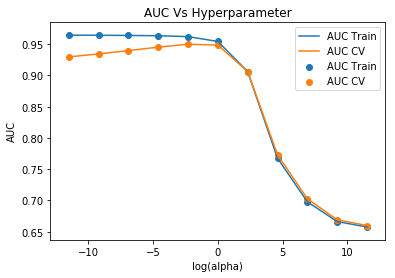

Optimal alpha for which AUC is maximum : 0.1


In [146]:
import math
alpha_values = [10**-5,10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4,10**5]

for i in alpha_values:
    naive = MultinomialNB(alpha = i,class_prior = [0.5,0.5])
    naive.fit(final_x_train, y_train)
    
    y_train_pred_prob = naive.predict_proba(final_x_train)[:,1]
    y_cv_pred_prob = naive.predict_proba(final_x_cv)[:,1]
    
    auc_train.append(roc_auc_score(y_train,y_train_pred_prob))
    auc_cv.append(roc_auc_score(y_cv,y_cv_pred_prob))


    
optimal_alpha = alpha_values[auc_cv.index(max(auc_cv))]
alpha_values = [np.log(x) for x in alpha_values]

plt.plot(alpha_values, auc_train, label='AUC Train')
plt.scatter(alpha_values, auc_train, label='AUC Train')
plt.plot(alpha_values,auc_cv,label = 'AUC CV')
plt.scatter(alpha_values,auc_cv,label = 'AUC CV')

plt.title('AUC Vs Hyperparameter')
plt.xlabel('log(alpha)')
plt.ylabel('AUC')
plt.legend()
plt.show()

print('Optimal alpha for which AUC is maximum :',optimal_alpha)


#### Testing with Test data

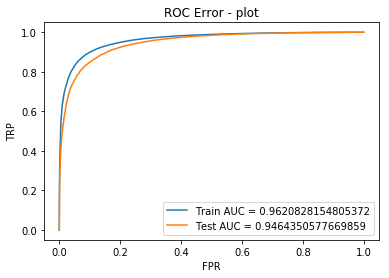

In [147]:
#Roc for alpha = 1
naive = MultinomialNB(alpha= optimal_alpha)
naive.fit(final_x_train,y_train)

train_prob = naive.predict_proba(final_x_train)[:,1]
test_prob = naive.predict_proba(final_x_test)[:,1]


train_fpr, train_tpr, thresholds = metrics.roc_curve(y_train, train_prob )
test_fpr, test_tpr, thresholds1 = metrics.roc_curve(y_test,test_prob)

plt.plot(train_fpr, train_tpr, label='Train AUC = ' + str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr, label = 'Test AUC = ' + str(auc(test_fpr,test_tpr)))

plt.xlabel('FPR')
plt.ylabel('TRP')
plt.title('ROC Error - plot')
plt.legend()
plt.show()


#### Confusion Matrix

Confusion Matrix for train data


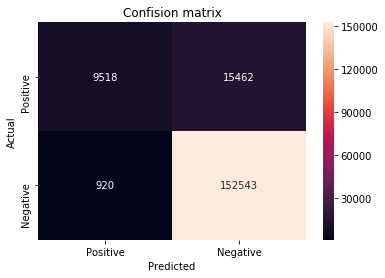

Confusion matrix for test data


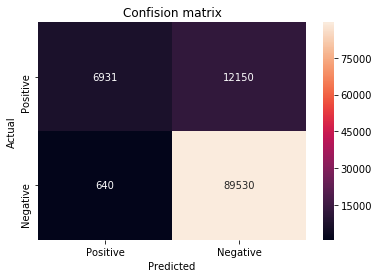

In [148]:
#confusion matrix using heatmap for train data
print('Confusion Matrix for train data')
conf_matr = confusion_matrix(y_train, naive.predict(final_x_train))
class_labes = ['Positive','Negative']
df = pd.DataFrame(conf_matr, index= class_labes, columns=class_labes)
sb.heatmap(df, annot= True ,fmt = 'd')
plt.title('Confision matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
#confusion matrix using heatmap for test data

print('Confusion matrix for test data')
conf_matr = confusion_matrix(y_test, naive.predict(final_x_test))
class_labes = ['Positive','Negative']
df = pd.DataFrame(conf_matr, index= class_labes, columns=class_labes)
sb.heatmap(df, annot= True ,fmt = 'd')
plt.title('Confision matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### [5.5.1] Top 10 important features of positive class

In [149]:
naive = MultinomialNB(alpha = optimal_alpha)
naive.fit(final_x_train,y_train)

features = naive.feature_log_prob_ #log probability of features given a class
feature_names = tf_idf_vect.get_feature_names()
positive_features = np.argsort(features[1])[::-1] # a[::-1] all items in the array, reversed
negative_features = np.argsort(features[0])[::-1] # Returns the indices that would sort an array
print("Top 10 important features of positive class from BOW")

# for i in list(positive_features[0:10]):
for i in list(positive_features[0:10]):
    print(feature_names[i])


Top 10 important features of positive class from BOW
not
great
364171
good
tea
coffee
love
like
best
product


### [5.5.2] Top 10 important features of negative class from

In [150]:
print("Top 10 important features of negative class from BOW")
for i in list(negative_features[0:10]):
    print(feature_names[i])

Top 10 important features of negative class from BOW
not
like
364171
taste
product
would
coffee
one
flavor
no


# [6] Conclusions

In [152]:
# compare all your models 
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ['Vectorizer','Feature Engineering','Hyperameter(Alpha)','AUC']
x.add_row(['BOW','Not featured ',1,0.91])
x.add_row(['TFIDF','Not featured ',0.1,0.92])
x.add_row(['BOW','featured',1,0.94])
x.add_row(['TFIDF','featured',0.1,0.94])
print(x)

+------------+---------------------+--------------------+------+
| Vectorizer | Feature Engineering | Hyperameter(Alpha) | AUC  |
+------------+---------------------+--------------------+------+
|    BOW     |    Not featured     |         1          | 0.91 |
|   TFIDF    |    Not featured     |        0.1         | 0.92 |
|    BOW     |       featured      |         1          | 0.94 |
|   TFIDF    |       featured      |        0.1         | 0.94 |
+------------+---------------------+--------------------+------+


## [7] Observations

- >  when summary of every product is added to the actual reviews then it gives better performance as compared to the model which takes only the text of the reviews in both bow and tfidf vectorization
- > tfidf is haviing little edge as compared to Bow vectorizer[TEXT] vectorizer as it gives better stats
- > Naive bayes is the simplest algorithm and it takes very much less time then KNN.
- > for feature engineering and found that after feature engineering our auc increased